# 鐵達尼號 - 特徵工程
本次的課程將學習如何實作二元分類的模型，鐵達尼號是在kaggle上很有名的機器學習入門級比賽，目的是利用船上的乘客資料來預測他們是否能在船難存活；藉由此項專案將學會如何使用python裡的套件pandas和numpy來操作資料、並利用matplotlib、seaborn視覺化資料，以及用scikit-learn來建構模型。

### 環境提醒及備註
在執行本範例前請先確認Jupyter筆記本設置是否正確，首先點選主選單的「修改」─「筆記本設置」─「運行類別」，選擇「Python3」，同時將「硬件加速器」下拉式選單由「None」改成「GPU」，再按「保存」。

### 課程架構
在鐵達尼號的專案中，將帶著學員建構一個機器學習的模型，並進行乘客生存率預測，主要包括以下四個步驟：

>1.   如何進行資料前處理(Processing)

>2.   如何實作探索式數據分析(Exploratory Data Analysis)

>3.   如何導入特徵工程(Feature Engineering)

>4.   如何選擇模型並評估其效果(Model&Inference) 

---

**3.1 載入所需套件**

---

In [1]:
# 3-1
# 首先載入所需套件，一般會利用import (package_name) as (xxx) 來簡化套件名稱，使得之後呼叫它們時更方便

import pandas as pd # 主要資料型態為series以及dataframe，功能以numpy為基礎再延伸更多進階的操作
import numpy as np # 操作陣列型態資料的套件
import matplotlib.pyplot as plt # 基本的繪圖套件
import seaborn as sns # 基於matplotlib提供更多高階視覺化的套件

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

import warnings
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# 3-2
# 可以用pandas裡面的函式來讀取csv檔，使用方法為pd.read_csv('檔案名稱')

# 訓練資料
train = pd.read_csv("train/train.csv") 

# 測試資料
test = pd.read_csv("test/test.csv") 

# 將訓練及測試資料結合以利後續的資料前處理
combine = [train, test] 
# 使用type()查看物件的型態，可以確認我們讀取後的檔案型態為datarframe
type(test)

pandas.core.frame.DataFrame

In [3]:
# 3-3
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


---

**3.2 特徵轉換**

---

In [4]:
# 3-4
# 使用shape()函式，可以看到train data與test data資料表的row與column數量

print("Before", train.shape, test.shape, combine[0].shape , combine[1].shape)

train = train.drop(['Ticket', 'Cabin'],axis=1)
test = test.drop(['Ticket', 'Cabin'],axis=1) 
combine = [train, test]

"After", train.shape, test.shape, combine[0].shape , combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

In [5]:
# 3-5
# 首先從乘客名字裡建立一個新的特徵"Titile"，Title是乘客的頭銜，它隱含著乘客的性別、婚姻狀況甚至是社經地位等。

# 用正規表達式將Title從Name裡面析取出來
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
# 觀察Title與性別之間的分佈
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [6]:
# 3-6
# 將Title這個特徵從文字轉換成類別資料，從上個步驟發現，大部分的Title數量其實很少，於是可以將這些數量過少的歸類成Rare

# 用dictionary的方法可以將key(Title)映射(mapping)至對應的value(類別資料)
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1.0


In [7]:
# 3-7
# 轉換完之後將Name這個特徵丟掉，因為我們已經從它析取出可用的資訊了

train = train.drop(['Name', 'PassengerId'], axis=1)
# 用drop丟掉Name, axis=1表示column，axis=0則表示row
test = test.drop(['Name'], axis=1) 
combine = [train, test]
train.shape, test.shape

((891, 9), (418, 9))

---

**3.3 轉換類別資料**

---
同樣地也需要將性別從文字轉換成類別的資料

In [8]:
# 3-8
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1.0
1,1,1,1,38.0,1,0,71.2833,C,3.0
2,1,3,1,26.0,0,0,7.9250,S,2.0
3,1,1,1,35.0,1,0,53.1000,S,3.0
4,0,3,0,35.0,0,0,8.0500,S,1.0


處理連續數值型態特徵的缺值問題

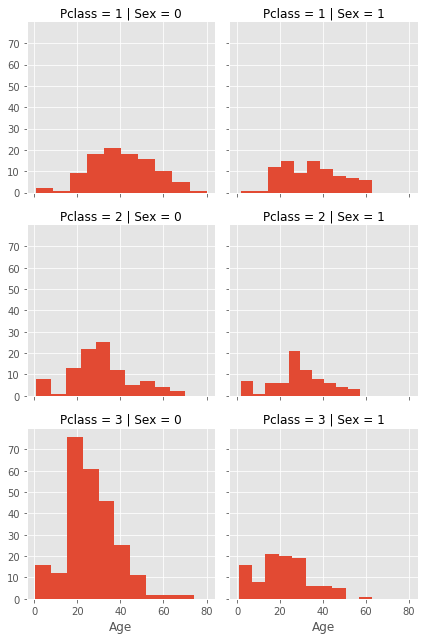

In [9]:
# 3-9
# 觀察各艙房中男女乘客的年齡分佈(Age)

g = sns.FacetGrid(train, row='Pclass', col='Sex') 
g.map(plt.hist, 'Age')

In [10]:
# 3-10
# 依照艙房等級與性別來補足年齡的缺值

# np.zeros可用來建構0的陣列，(2,3)是參數shape的值，可視為2*3的矩陣
guess_ages = np.zeros((2,3)) 

# 將用這個矩陣存取用來補足缺值的值
guess_ages 

array([[0., 0., 0.],
       [0., 0., 0.]])

In [11]:
# 3-11

for dataset in combine:
    for i in range(0, 2): # 性別
        for j in range(0, 3): # 艙房等級
            guess = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna() # 將艙房與性別的缺值去除

            age_guess = guess.median() # 從去除缺值後的資料中選出中位數

            guess_ages[i,j] = round(age_guess) # 將中位數四捨五入
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j] # 將有缺值的地方補上中位數

    dataset['Age'] = dataset['Age'].astype(int) # 將年齡轉換成整數型態

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1.0
1,1,1,1,38,1,0,71.2833,C,3.0
2,1,3,1,26,0,0,7.9250,S,2.0
3,1,1,1,35,1,0,53.1000,S,3.0
4,0,3,0,35,0,0,8.0500,S,1.0


In [12]:
# 3-12
# 處理完年齡缺值後，接著轉換成類別型態的資料，也就是以年齡的區間表示年齡，這有助於更容易觀察年齡與存活率的關係

# pd.cut可以將連續型的數值資料均分成指定的數量，例如這邊想將年齡做5等分
train['AgeBand'] = pd.cut(train['Age'], 5) 

# 觀察每個年齡區間的存活率
train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [13]:
# 3-13
# 依照算出來的年齡區間將年齡轉換成類別資料

for dataset in combine:    
    # loc這個函式可以找出符合[]內條件的資料
    # 將符合該區間的年齡找出並以相應的類別取代
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0 
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1.0,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3.0,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2.0,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3.0,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1.0,"(32.0, 48.0]"


In [14]:
# 3-14
# 將轉換完類別資料之後，將不需要的年齡區間丟掉

train = train.drop(['AgeBand'], axis=1)
combine = [train, test]
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1.0
1,1,1,1,2,1,0,71.2833,C,3.0
2,1,3,1,1,0,0,7.9250,S,2.0
3,1,1,1,2,1,0,53.1000,S,3.0
4,0,3,0,2,0,0,8.0500,S,1.0


---

**3.4 特徵合併**

---
由於SibSp(兄弟姐妹與配偶)與Parch(父母與小孩)這兩個特徵其實概念上都屬於"家人"，因此可以把它們合併成同一個類別，也就是家庭大小

In [15]:
# 3-15
for dataset in combine:
    # 計算家庭大小，+1表示乘客本人也算在內
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1 

# 觀察家庭大小與存活率的關係
train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [16]:
# 3-16
# 觀察家庭大小跟存活率的關係之後，發現兩者間並無明顯關係，因此我們嘗試可將此特徵轉換成"IsAlone"，表示乘客是否單身搭乘
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [17]:
# 3-17
# 接著就可以丟掉Parch, SibSp和FamilySize這些特徵
train = train.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test = test.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train, test]

train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1.0,0
1,1,1,1,2,71.2833,C,3.0,0
2,1,3,1,1,7.9250,S,2.0,1
3,1,1,1,2,53.1000,S,3.0,0
4,0,3,0,2,8.0500,S,1.0,1


---

**3.5 加入年齡以及艙房的交互作用項**

---
交互作用項可以捕捉年齡以及艙房等級之間對存活率的解釋能力，也就是說，認為年齡對存活率的解釋能力其實也與艙房等級有關；同理艙房等級也是

In [18]:
# 3-18

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


---

**3.6 搭乘港口資訊的缺值補上**

---

In [19]:
# 3-19
# 使用mode可以找出資料中最常見的值

freq_port = train.Embarked.dropna().mode()[0] 
freq_port
for dataset in combine:
    # 將缺值以最常見的值補上
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

# 觀察搭乘港口與存活率關係
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


---

**3.7 文字型態轉數字**

---

In [20]:
# 3-20
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1.0,0,3
1,1,1,1,2,71.2833,1,3.0,0,2
2,1,3,1,1,7.9250,0,2.0,1,3
3,1,1,1,2,53.1000,0,3.0,0,2
4,0,3,0,2,8.0500,0,1.0,1,6


---

**3.8 處理票價特徵**

---
有一個缺值需要補上，由於票價是連續型的數值變數，且缺值只有一個，因此不需再根據與其他特徵的關聯假設猜測缺值，這裡使用中位數補上即可

In [21]:
# 3-21
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1.0,1,6
1,893,3,1,2,7.0000,0,3.0,0,6
2,894,2,0,3,9.6875,2,1.0,1,6
3,895,3,0,1,8.6625,0,1.0,1,3
4,896,3,1,1,12.2875,0,3.0,0,3


In [22]:
# 3-22
# 將票價分成四等分區間
train['FareBand'] = pd.qcut(train['Fare'], 4)

# 觀察各區間的存活率
train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [23]:
# 3-23

for dataset in combine:
    # 將每個區間的票價轉換成類別型態
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train = train.drop(['FareBand'], axis=1) # 轉換完成後丟掉票價區間
combine = [train, test] # 將train與test合併
    
train.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1.0,0,3
1,1,1,1,2,3,1,3.0,0,2
2,1,3,1,1,1,0,2.0,1,3
3,1,1,1,2,3,0,3.0,0,2
4,0,3,0,2,1,0,1.0,1,6
5,0,3,0,1,1,2,1.0,1,3
6,0,1,0,3,3,0,1.0,1,3
7,0,3,0,0,2,0,4.0,0,0
8,1,3,1,1,1,0,3.0,0,3
9,1,2,1,0,2,1,3.0,0,0


In [24]:
# 3-24
test.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1.0,1,6
1,893,3,1,2,0,0,3.0,0,6
2,894,2,0,3,1,2,1.0,1,6
3,895,3,0,1,1,0,1.0,1,3
4,896,3,1,1,1,0,3.0,0,3
5,897,3,0,0,1,0,1.0,1,0
6,898,3,1,1,0,2,2.0,1,3
7,899,2,0,1,2,0,1.0,0,2
8,900,3,1,1,0,1,3.0,1,3
9,901,3,0,1,2,0,1.0,0,3


---

**3.9 輸出整理完的資料**

---
把整理完的資料，輸出成excel的格式

In [25]:
# 3-25
train.to_excel('train/train_new.xls')

In [26]:
# 3-26
test.to_excel('test/test_new.xls')

------